In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Multiply, Add, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2

In [12]:
class_labels = pd.Series(["Walking", "Jogging", "walking_stairs_updown", "stumble_while_walking", "Fall_Recovery", "Fall_Initiation", "Impact", "Aftermath"])
n_classes = len(class_labels)
n_classes

8

In [13]:
final_data = np.load("..\\full_and_half_Final_data.npy")
label = np.load("..\\full_and_half_label.npy")

In [14]:
final_data.shape

(11674, 200, 6)

In [15]:
final_data

array([[[ 3.70108067e-01,  1.84242152e+00, -2.09895659e+00,
          2.44204856e-01, -1.14811268e+00, -1.31094327e+00],
        [ 3.10724502e-01,  1.96257422e+00, -1.87010434e+00,
          7.64817407e-02, -1.28869163e+00, -1.17169055e+00],
        [-1.04960451e-01,  1.91451314e+00, -1.64125208e+00,
         -7.20730188e-02, -1.38753620e+00, -1.06573740e+00],
        ...,
        [-6.09720751e-01,  6.41615423e-02,  1.51182342e+00,
         -3.37363067e-02, -1.84222124e+00,  4.14579566e-01],
        [-7.28487880e-01,  4.01310021e-02,  1.56267948e+00,
          1.77115610e-01, -1.91910036e+00,  5.08423791e-01],
        [-8.17563227e-01, -1.04052239e-01,  1.86781582e+00,
          4.21512150e-01, -1.98938983e+00,  6.08322481e-01]],

       [[-7.14277170e-01,  2.00488654e-01,  1.69094994e+00,
          1.68401107e-01, -1.84585613e+00,  5.43452106e-01],
        [-7.71764267e-01,  2.00488654e-01,  1.75142020e+00,
          3.39260497e-01, -1.88641103e+00,  5.58390904e-01],
        [-7.52601

In [16]:
label.shape

(11674,)

In [17]:
label

array([0, 0, 0, ..., 5, 6, 7], dtype=int64)

In [6]:
mylabel=np.copy(label)

In [18]:
label = to_categorical(label, n_classes)
label.shape

(11674, 8)

In [19]:
label

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [20]:
final_data = zscore(final_data, axis=1)

In [21]:
final_data

array([[[ 3.70108067e-01,  1.84242152e+00, -2.09895659e+00,
          2.44204856e-01, -1.14811268e+00, -1.31094327e+00],
        [ 3.10724502e-01,  1.96257422e+00, -1.87010434e+00,
          7.64817407e-02, -1.28869163e+00, -1.17169055e+00],
        [-1.04960451e-01,  1.91451314e+00, -1.64125208e+00,
         -7.20730188e-02, -1.38753620e+00, -1.06573740e+00],
        ...,
        [-6.09720751e-01,  6.41615423e-02,  1.51182342e+00,
         -3.37363067e-02, -1.84222124e+00,  4.14579566e-01],
        [-7.28487880e-01,  4.01310021e-02,  1.56267948e+00,
          1.77115610e-01, -1.91910036e+00,  5.08423791e-01],
        [-8.17563227e-01, -1.04052239e-01,  1.86781582e+00,
          4.21512150e-01, -1.98938983e+00,  6.08322481e-01]],

       [[-7.14277170e-01,  2.00488654e-01,  1.69094994e+00,
          1.68401107e-01, -1.84585613e+00,  5.43452106e-01],
        [-7.71764267e-01,  2.00488654e-01,  1.75142020e+00,
          3.39260497e-01, -1.88641103e+00,  5.58390904e-01],
        [-7.52601

In [22]:
final_data.shape

(11674, 200, 6)

In [23]:
label.shape

(11674, 8)

In [24]:
I_Shape = final_data.shape[1:]
print(I_Shape)

(200, 6)


In [26]:
# Define selective kernel convolution block
def selective_kernel_conv(inputs, kernel_sizes, filters):
    # Perform convolution with different kernel sizes
    conv_outputs = []
    for size in kernel_sizes:
        conv_output = Conv1D(filters=filters, kernel_size=size, padding='same', activation='relu')(inputs)
        conv_outputs.append(conv_output)

    # Use an Add layer to combine the convolution outputs
    if len(conv_outputs) > 1:
        combined_output = Add()(conv_outputs)
    else:
        combined_output = conv_outputs[0]

    # Squeeze and Excitation mechanism
    excitation = GlobalAveragePooling1D()(combined_output)
    excitation = Dense(len(kernel_sizes), activation='relu')(excitation)
    excitation = Dense(filters, activation='sigmoid')(excitation)
    excitation = tf.expand_dims(excitation, axis=1)
    
    # Weighted output of the convolution outputs
    weighted_output = Multiply()([combined_output, excitation])
    
    return weighted_output

# Define attention mechanism
def attention_block(inputs):
    # Compute attention scores
    attention_scores = Dense(inputs.shape[-1], activation='softmax')(inputs)
    
    # Apply attention scores to the inputs
    attention_output = Multiply()([inputs, attention_scores])
    
    return attention_output

# Define AMSKNet model
def build_amsknet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Selective Kernel Convolution Layers
    x = selective_kernel_conv(inputs, kernel_sizes=[3, 5, 7], filters=64)
    x = attention_block(x)
    
    x = selective_kernel_conv(x, kernel_sizes=[3, 5, 7], filters=128)
    x = attention_block(x)
    
    # Global Average Pooling and Dense layers
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [27]:
input_shape = I_Shape
num_classes = n_classes

In [48]:
model = build_amsknet(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 200, 6)]             0         []                            
                                                                                                  
 conv1d_15 (Conv1D)          (None, 200, 64)              1216      ['input_4[0][0]']             
                                                                                                  
 conv1d_16 (Conv1D)          (None, 200, 64)              1984      ['input_4[0][0]']             
                                                                                                  
 conv1d_17 (Conv1D)          (None, 200, 64)              2752      ['input_4[0][0]']             
                                                                                            

In [49]:
split_index = int(0.8 * len(final_data))
train_data, val_data = final_data[:split_index], final_data[split_index:]
train_label, val_label = label[:split_index], label[split_index:]

history = model.fit(
    train_data,
    train_label,
    batch_size=32,
    epochs=50,
    validation_data=(val_data, val_label),
    verbose=1
)

val_loss, val_accuracy = model.evaluate(val_data, val_label, verbose=1)

print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

Epoch 1/50
292/292 [==============================] - 17s 53ms/step - loss: 1.7557 - accuracy: 0.3262 - val_loss: 1.6455 - val_accuracy: 0.3837
Epoch 2/50
292/292 [==============================] - 25s 86ms/step - loss: 1.2459 - accuracy: 0.5405 - val_loss: 1.4024 - val_accuracy: 0.4642
Epoch 3/50
292/292 [==============================] - 26s 89ms/step - loss: 1.0855 - accuracy: 0.6030 - val_loss: 1.3087 - val_accuracy: 0.4981
Epoch 4/50
292/292 [==============================] - 15s 51ms/step - loss: 0.9914 - accuracy: 0.6433 - val_loss: 1.1966 - val_accuracy: 0.5302
Epoch 5/50
292/292 [==============================] - 15s 51ms/step - loss: 0.9145 - accuracy: 0.6736 - val_loss: 1.1768 - val_accuracy: 0.5529
Epoch 6/50
292/292 [==============================] - 15s 51ms/step - loss: 0.8400 - accuracy: 0.7018 - val_loss: 1.1527 - val_accuracy: 0.5636
Epoch 7/50
292/292 [==============================] - 15s 53ms/step - loss: 0.7907 - accuracy: 0.7229 - val_loss: 1.0964 - val_accuracy:

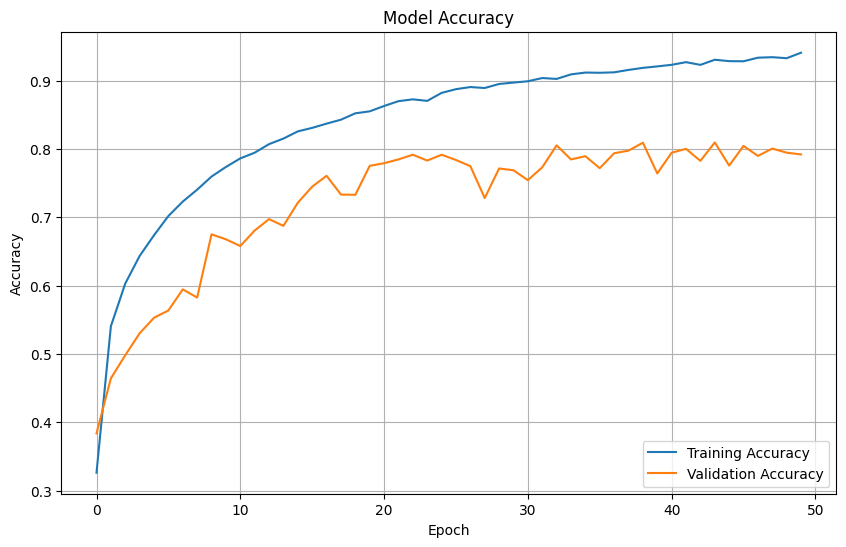

In [50]:
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_accuracy(history)

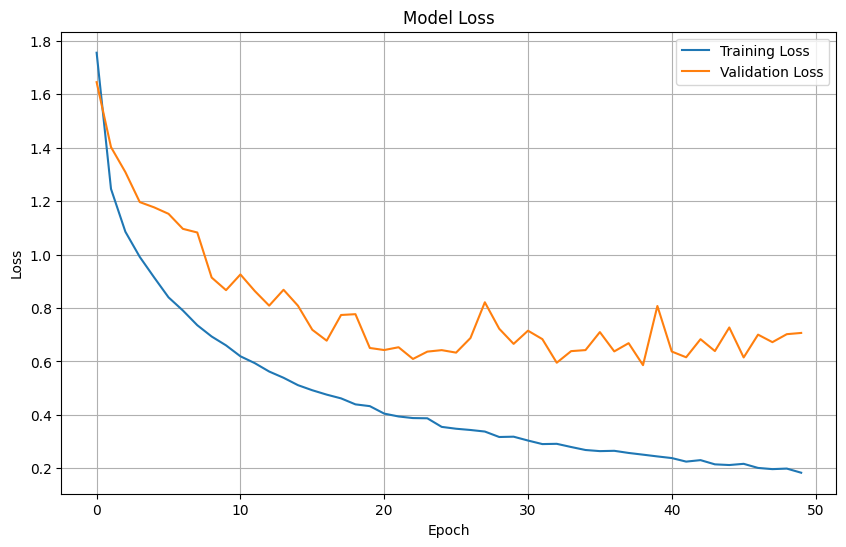

In [51]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

plot_loss(history)

In [28]:
def selective_kernel_conv_reg(inputs, kernel_sizes, filters, use_bn=True, dropout_rate=0.3):
    conv_outputs = []
    for size in kernel_sizes:
        conv_output = Conv1D(filters=filters, kernel_size=size, padding='same', activation='relu', kernel_regularizer=l2(1e-4))(inputs)
        if use_bn:
            conv_output = BatchNormalization()(conv_output)
        conv_outputs.append(conv_output)

    if len(conv_outputs) > 1:
        combined_output = Add()(conv_outputs)
    else:
        combined_output = conv_outputs[0]

    excitation = GlobalAveragePooling1D()(combined_output)
    excitation = Dense(len(kernel_sizes), activation='relu')(excitation)
    excitation = Dense(filters, activation='sigmoid')(excitation)
    excitation = tf.expand_dims(excitation, axis=1)

    weighted_output = Multiply()([combined_output, excitation])
    
    if dropout_rate:
        weighted_output = Dropout(dropout_rate)(weighted_output)
    
    return weighted_output

# Define attention mechanism
def attention_block(inputs):
    # Compute attention scores
    attention_scores = Dense(inputs.shape[-1], activation='softmax')(inputs)
    
    # Apply attention scores to the inputs
    attention_output = Multiply()([inputs, attention_scores])
    
    return attention_output

def build_amsknet_reg(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = selective_kernel_conv_reg(inputs, kernel_sizes=[3, 5, 7], filters=64, dropout_rate=0.3)
    x = attention_block(x)
    
    x = selective_kernel_conv_reg(x, kernel_sizes=[3, 5, 7], filters=128, dropout_rate=0.3)
    x = attention_block(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

model_reg = build_amsknet_reg(input_shape, num_classes)
model_reg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
train_data, test_data, train_label, test_label = train_test_split(final_data, label, test_size=0.2, random_state=42)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size=0.25, random_state=42)

In [30]:
history = model_reg.fit(
    train_data,
    train_label,
    batch_size=32,
    epochs=50,
    validation_data=(val_data, val_label),
    verbose=1
)

Epoch 1/50
219/219 [==============================] - 24s 85ms/step - loss: 1.6686 - accuracy: 0.3734 - val_loss: 1.9385 - val_accuracy: 0.2942
Epoch 2/50
219/219 [==============================] - 31s 140ms/step - loss: 1.0503 - accuracy: 0.6298 - val_loss: 1.1497 - val_accuracy: 0.6548
Epoch 3/50
219/219 [==============================] - 19s 86ms/step - loss: 0.8486 - accuracy: 0.7246 - val_loss: 0.7597 - val_accuracy: 0.7542
Epoch 4/50
219/219 [==============================] - 17s 79ms/step - loss: 0.7347 - accuracy: 0.7641 - val_loss: 0.6504 - val_accuracy: 0.8009
Epoch 5/50
219/219 [==============================] - 18s 82ms/step - loss: 0.6720 - accuracy: 0.7854 - val_loss: 0.6224 - val_accuracy: 0.8081
Epoch 6/50
219/219 [==============================] - 18s 83ms/step - loss: 0.6119 - accuracy: 0.8068 - val_loss: 0.5987 - val_accuracy: 0.8180
Epoch 7/50
219/219 [==============================] - 19s 85ms/step - loss: 0.5754 - accuracy: 0.8238 - val_loss: 0.6045 - val_accuracy

In [31]:
val_loss, val_accuracy = model_reg.evaluate(val_data, val_label, verbose=1)

print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

73/73 [==============================] - 1s 17ms/step - loss: 0.5601 - accuracy: 0.8475
Validation Loss: 0.5601
Validation Accuracy: 0.8475


In [33]:
test_loss, test_accuracy = model_reg.evaluate(test_data, test_label, verbose=1)
test_accuracy

73/73 [==============================] - 1s 17ms/step - loss: 0.5596 - accuracy: 0.8433


0.843254804611206